# MAESTRO Dataset
Mouais

## Score-based approach

### Pre-process
Pas utile si `data/piece0.csv` existe déjà 

In [1]:
import pandas as pd
from music21 import converter
import music21
from tqdm.autonotebook import tqdm
from IPython.core.display import HTML

class PieceDataFrame:
    """
        Object containing a dataframe representing a MusicXML with a MIDI-like representation
        (only NOTE_ON events)
    """
    
    def __init__(self, filename):
        # Initializes the music21.stream object from a MusicXML and creates the dataframe
        assert "musicxml" in filename, "WARNING : not musicXML file !"
        
        self.data = {
            'note' : [],
            'velocity' : [],
            'time_symb' : [],
            'pitch' : [],
            'hand' : [],
            'time_wav' : []
        }
        
        print("Parsing musicxml...")
        self.score = converter.parse(filename)
        self.n_bar = len(self.score.recurse(classFilter='Measure'))
        self.metro_mark = float(list(self.score.recurse(classFilter="MetronomeMark"))[0].durationToSeconds(1))
        self.df = None
        self.make_df()
        
    
    def update_data(self, note, offset, hand, velocity=None):
        # Updates the data dict from a NOTE_ON event parsed in the music21.stream
        self.data['note'].append(note.pitch.midi)
        this_velocity = note.volume.velocity if velocity is None else velocity
        self.data['velocity'].append(this_velocity)
        self.data['time_symb'].append(offset)
        self.data['pitch'].append(note.pitch)
        self.data['hand'].append(hand)
        self.data['time_wav'].append(float(offset) * self.metro_mark)
        

    def make_df(self):
        # Makes the dataframe
        pbar = tqdm(total=self.n_bar, desc="Analyzing...")
        for part_staff in self.score.recurse(classFilter=['PartStaff']):
            this_hand = "R" if "Staff1" in part_staff.id else "L"
            # Loop on measures to get the offset measure
            for measure in part_staff.recurse(classFilter=['Measure']):
                # Loop on notes AND chords
                for elt in measure.recurse(classFilter=['Note', 'Chord']):
                    # Case note : direct update
                    if isinstance(elt, music21.note.Note):
                        this_offset = elt.offset + measure.offset
                        self.update_data(elt, this_offset, this_hand)
                        # NOTE_OFF
                        self.update_data(elt, this_offset + elt.duration.quarterLength, this_hand, velocity=0) 
                    # Case chord : loop on intern notes
                    elif isinstance(elt, music21.chord.Chord):
                        for note in elt:
                            this_offset = elt.offset + measure.offset
                            self.update_data(note, this_offset, this_hand)
                            # NOTE_OFF
                            self.update_data(note, this_offset + elt.duration.quarterLength, this_hand, velocity=0) 
                pbar.update(1)
        pbar.close()
        
        self.df = pd.DataFrame(self.data)
        self.df = self.df.sort_values(by='time_symb', ignore_index=True)
        
    
    def get_dataframe(self):
        return self.df
    
    def display_notebook(self):
        display(HTML(self.df.to_html()))
        
    def get_score(self):
        return self.score
    
    def export_to_csv(self, filename):
        self.df.to_csv(filename, index=False)
        print(f"Exported to {filename}")

<ipython-input-1-1dee5ce870cb>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [37]:
filename = 'data/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.musicxml'
piece0 = PieceDataFrame(filename)

Parsing musicxml...


In [39]:
piece0.export_to_csv('data/piece0.csv')

Exported to data/piece0.csv


### Inject

In [40]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient, Point, WriteOptions
import rx
from rx import operators as ops
from collections import OrderedDict
from csv import DictReader
from datetime import datetime

In [41]:
bucket = "maestro"
org = "obd_influxdb"
token = "DkqpJF-KB6oCD25k7E8woeHxK0deggIpNyDxFeoszhLogSRrYLKdYMdcZjVGXyutwFSFBfLD5-Jkbah6wt9ujA=="
url="http://localhost:8086"

client = influxdb_client.InfluxDBClient(
        url=url,
        token=token,
        org=org,
        timeout=60_000
    )

In [42]:
df = pd.read_csv('data/piece0.csv')
pbar = tqdm(total=len(df))
write_api = client.write_api(write_options=SYNCHRONOUS)

    
for i, row in df.iterrows():
    #Format 2021-10-06T20:05:38Z
    # Fields are data, Tags are metadata
    this_time = datetime.utcfromtimestamp(row['time_wav']).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    p = influxdb_client.Point("piece0") \
        .tag("note", row['note']) \
        .field("velocity", row['velocity']) \
        .field("hand", int(row['hand'] == 'R')) \
        .time(this_time)
    write_api.write(bucket=bucket, org=org, record=p, time_precision="ms")
    pbar.update(1)
pbar.close()

In [35]:
def delete_db():
    delete_api = client.delete_api()
    start = "1970-01-01T00:00:00Z"
    stop = "2022-02-01T00:00:00Z"
    delete_api.delete(start, stop, '_measurement="piece0"', bucket=bucket, org=org)
    print("Done !")
    
delete_db()

Done !


---
Quick query :

<code>from(bucket:"maestro")
  |> range(start: 0, stop: now())</code>

**Dashboard**

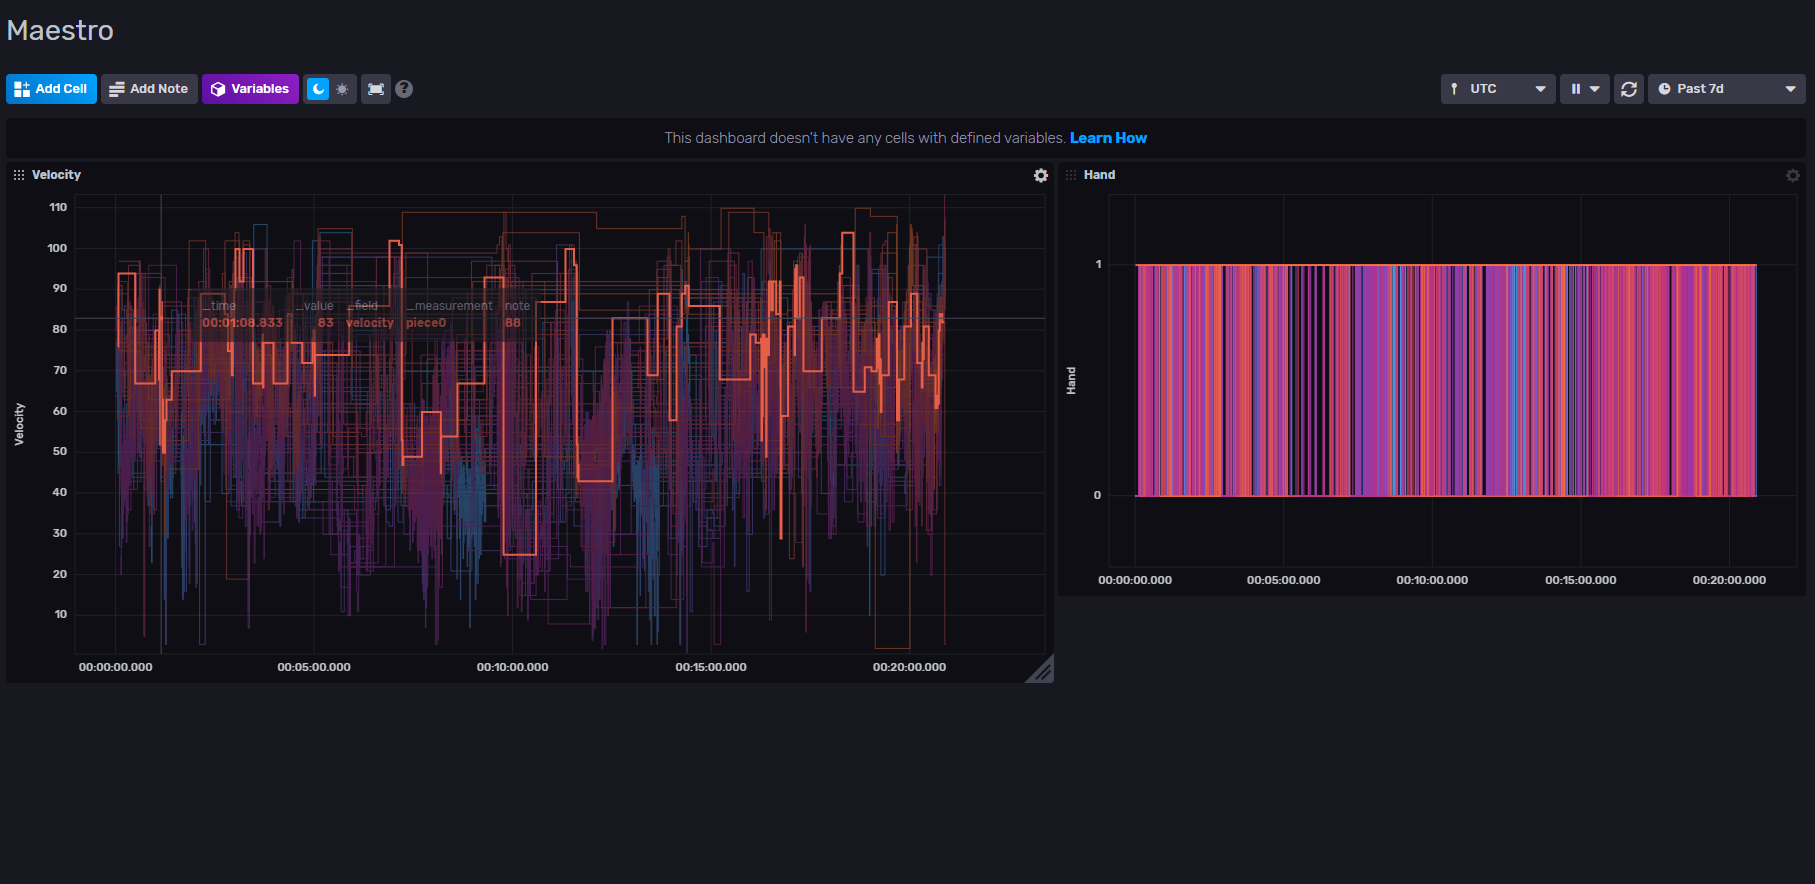

## Audio

In [2]:
import librosa
y, sr = librosa.load('data/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3')

C:\Users\Dinh-Viet-Toan\AppData\Roaming\Python\Python38\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


 Fs = 22050, x.shape = (27696763,), x.dtype = float32


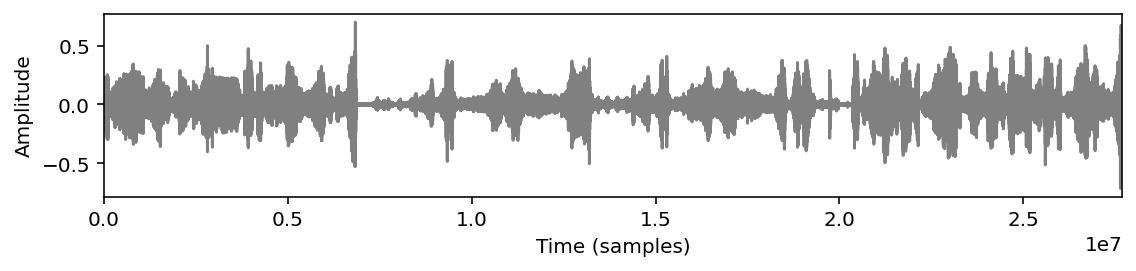

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt

def print_signal(x, Fs, text=''):
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
print_signal(y, sr)

In [4]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient, Point, WriteOptions
import rx
from rx import operators as ops
from collections import OrderedDict
from csv import DictReader
from datetime import datetime

In [5]:
bucket = "maestro_audio"
org = "obd_influxdb"
token = "DkqpJF-KB6oCD25k7E8woeHxK0deggIpNyDxFeoszhLogSRrYLKdYMdcZjVGXyutwFSFBfLD5-Jkbah6wt9ujA=="
url="http://localhost:8086"

client = influxdb_client.InfluxDBClient(
        url=url,
        token=token,
        org=org,
        timeout=60_000
    )

 Fs = 22050, x.shape = (441000,), x.dtype = float32


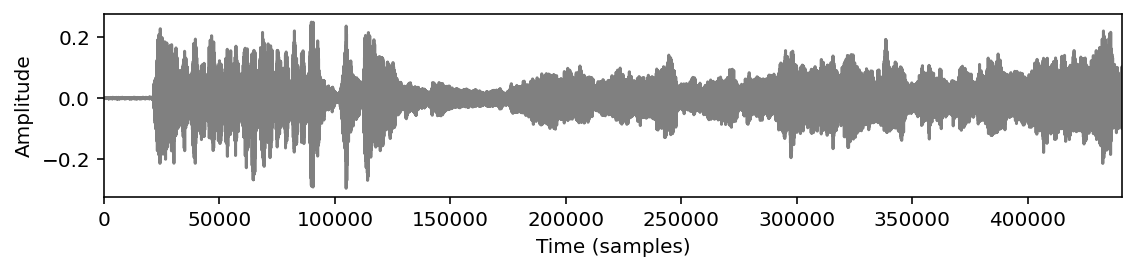

In [36]:
part_y = y[:20*sr]
print_signal(part_y, sr)

In [37]:
assert False, "Do not run this cell"

write_api = client.write_api(write_options=SYNCHRONOUS)

pbar = tqdm(total=len(part_y))
for i, pt in enumerate(part_y):
    this_time = datetime.utcfromtimestamp(i / sr).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    p = influxdb_client.Point("piece0") \
        .field("y", pt) \
        .time(this_time)
    write_api.write(bucket=bucket, org=org, record=p, time_precision="ms")
    pbar.update(1)
pbar.close()

AssertionError: Do not run this cell

In [38]:
df_y = pd.DataFrame({
    'unix_time' : np.arange(len(part_y)) / sr,
    'time' : np.arange(len(part_y)) / sr,
    'y' : part_y
})

def to_str_time(unix_time):
    return datetime.utcfromtimestamp(int(unix_time)).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
df_y['time'] = pd.to_datetime(df_y['time'],unit='s')

In [39]:
df_y

,unix_time,time,y
0,0.000000,1970-01-01 00:00:00.000000000,0.000047
1,0.000045,1970-01-01 00:00:00.000045351,0.000276
2,0.000091,1970-01-01 00:00:00.000090703,0.000318
3,0.000136,1970-01-01 00:00:00.000136054,0.000287
4,0.000181,1970-01-01 00:00:00.000181406,0.000269
...,...,...,...
440995,19.999773,1970-01-01 00:00:19.999773243,0.023354
440996,19.999819,1970-01-01 00:00:19.999818594,0.010554
440997,19.999864,1970-01-01 00:00:19.999863946,-0.010816
440998,19.999909,1970-01-01 00:00:19.999909297,-0.019116


In [42]:
df_y.to_csv('data/maestro_part_y.csv')

In [41]:
import rx
from rx import operators as ops

def parse_elt(elt):
#     print(elt)
    return influxdb_client.Point("piece0").field("y", float(elt['y'])).time(elt['time'])

datafile = 'data/maestro_part_y.csv'
data = rx.from_iterable(DictReader(open(datafile, 'r'))).pipe(ops.map(lambda row: parse_elt(row)))

write_api = client.write_api(write_options=WriteOptions(batch_size=50_000, flush_interval=10_000))
write_api.write(bucket=bucket, org=org, record=data)
write_api.close()

In [35]:
def delete_db():
    delete_api = client.delete_api()
    start = "1970-01-01T00:00:00Z"
    stop = "2022-02-01T00:00:00Z"
    delete_api.delete(start, stop, '_measurement="piece0"', bucket=bucket, org=org)
    print("Done !")
    
delete_db()

Done !


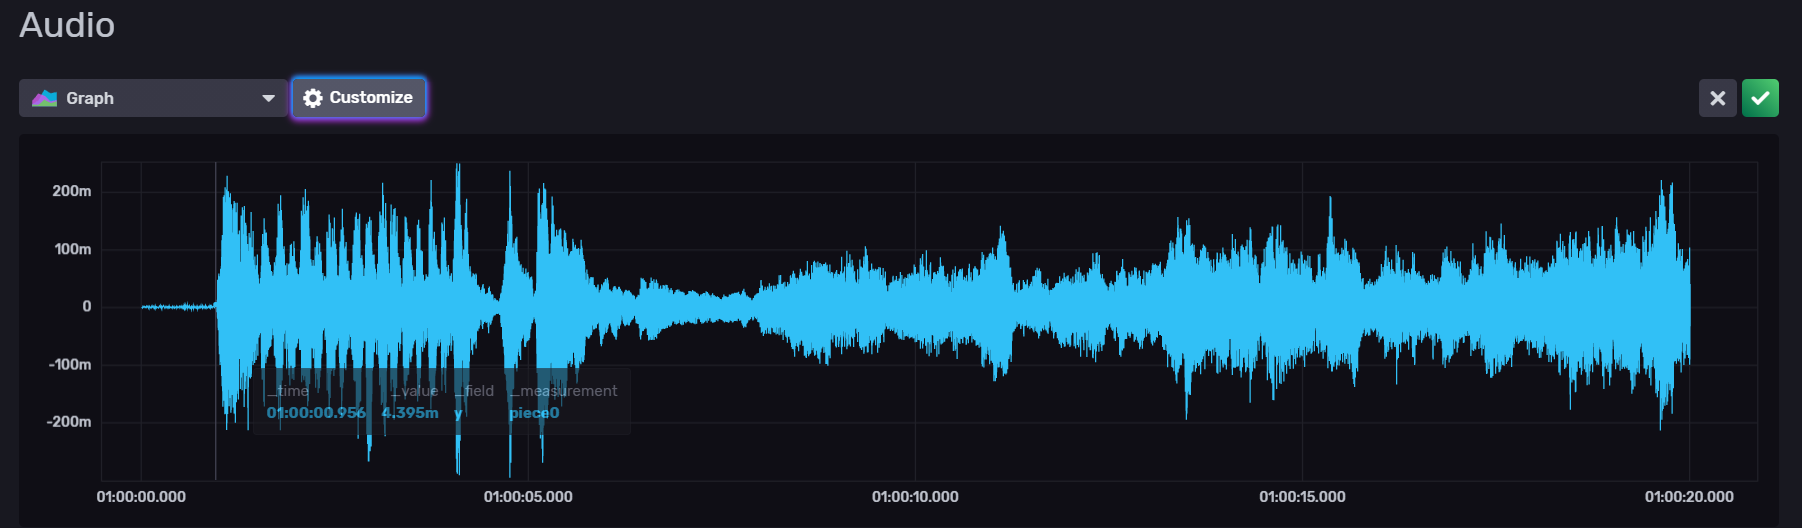

## Playground

In [19]:
df_piece0 = piece0.get_dataframe()
df_piece0.groupby('note').count()

,velocity,time_symb,pitch,hand,time_wav
note,,,,,
28,3,3,3,3,3
29,62,62,62,62,62
30,28,28,28,28,28
31,89,89,89,89,89
32,25,25,25,25,25
...,...,...,...,...,...
93,77,77,77,77,77
94,19,19,19,19,19
95,23,23,23,23,23
